# Purpose

The purpose is to load in the data and generate tensors for the data. This depends on the specified percentage of the dataset we want to output.

Also, there should be different sections of the data so that we can see what goes on at every moment. It should create a copy of the data whenever working with it so that we can see the before and after for the pipeline

It should be in linear order where each function does something and outputs the data from the end of that. Since we are not reusing variable names, we will have to plug in different variable names at different places if we want to change things

Also, operations should be functions then perhaps return a new dataset. If we do it like this, it makes it easier to compare things and run code multiple times

Summary:

* Sections, functions for different operations
* New variables/variable names for things
^ util functions like plotting, etc. are reusable
* Work linearly where we create the function in a cell, call it on data in the next cell
* At the end, should have an output to tensor function and it does that


# Imports

In [1]:
import utils
import constants
import time

start_time = time.time()

In [2]:
filename = 'part2preprocessing'
output_folder, num = utils.get_next_output_folder(f'outputs/{filename}_output')
config = constants.Config(filename,
                          output_folder = output_folder,
                          num_iteration=num,
                          frac_reviews_load=0.00001,
                          minimum_business_reviews=1)
# config = constants.Config(filename,
#                           output_folder = output_folder,
#                           num_iteration=num)
print("Output folder: ", output_folder)

Output folder:  outputs/part2preprocessing_output_4


In [3]:
# Import Libraries
import os
import json
import sys
import re
import pandas as pd
import kagglehub
import time
import datetime
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup, BertModel
from IPython.display import display, clear_output
import dask.dataframe as dd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

import traceback
import sys

import geopandas as gpd

import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')
nltk.download('stopwords')
try:
    nltk.download('averaged_perceptron_tagger')
except:
    pass
try:
    nltk.download('averaged_perceptron_tagger_eng')
except:
    pass


from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import spacy

os.system('./venv/bin/python -m spacy download en_core_web_sm')
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    nltk.download('punkt')
except:
    pass
try:
    nltk.download('punkt_tab')
except:
    pass

from nltk.tokenize import sent_tokenize


/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-06 23:37:34.159421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 23:37:34.816792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741322255.330250  289656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741322255.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /home/abhay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/abhay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load in all the data

In [4]:
def get_path():
    if os.path.exists("/kaggle"):
        return "/kaggle/input/yelp-dataset"
    elif os.path.exists('/home/abhaydesktop/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4'):
        return '/home/abhaydesktop/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4'
    else:
        return kagglehub.dataset_download("yelp-dataset/yelp-dataset")


def load_data(path, filename, total_data_num, frac=1.0):
    chunk_size = config.load_in_data_chunk_size
    rows_to_load = int(total_data_num * frac)
    df = pd.read_json(os.path.join(path, filename), lines=True, chunksize=chunk_size)
    
    data = []
    for chunk in df:
        data.append(chunk)
        if len(data) * chunk_size >= rows_to_load:
            break
    
    df = pd.concat(data)[:rows_to_load]
    return df



In [5]:
path = get_path()
print("Path to dataset files:", path)

print("\nDataset Load Times:\n")
start_time = time.time()
businesses_df = load_data(path, "yelp_academic_dataset_business.json", config.total_businesses_in_all, frac=config.frac_businesses_load)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Business Load Time: {elapsed_time:.4f} seconds")
print(f"Loaded in {config.frac_businesses_load * 100}% of businesses")

# start_time = time.time()
# tips_df = load_data(path, "yelp_academic_dataset_tip.json")
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Tips Load Time: {elapsed_time:.4f} seconds")

print(f"Loading in {config.frac_reviews_load * 100}% of reviews")
start_time = time.time()
reviews_df = load_data(path, "yelp_academic_dataset_review.json", config.total_reviews_in_all, frac=config.frac_reviews_load)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Review Load Time: {elapsed_time:.4f} seconds")
print(f"Loaded in {config.frac_reviews_load * 100}% of reviews")


Path to dataset files: /home/abhay/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4

Dataset Load Times:

Business Load Time: 2.4814 seconds
Loaded in 100% of businesses
Loading in 0.001% of reviews
Review Load Time: 1.1252 seconds
Loaded in 0.001% of reviews


In [6]:
print("Total businesses:", len(businesses_df))
print("Total reviews:", len(reviews_df))

print("Total different businesses in reviews:", len(reviews_df['business_id'].unique()))

Total businesses: 150346
Total reviews: 69
Total different businesses in reviews: 69


# Start filtering the data

This is in general filtering for the categories and text

In [7]:
def filter_min_business_reviews(rev_df: pd.DataFrame, min_reviews: int):
    return rev_df[rev_df['business_id'].map(rev_df['business_id'].value_counts()).ge(min_reviews)]


In [8]:
reviews_over_min_reviews = filter_min_business_reviews(reviews_df, config.minimum_business_reviews)
print(f"Number of reviews with at least {config.minimum_business_reviews} reviews for that business: {len(reviews_over_min_reviews)}")

Number of reviews with at least 1 reviews for that business: 69


In [9]:
def filter_out_businesses_with_null_categories(bus_df: pd.DataFrame):
    return bus_df[bus_df['categories'].notnull()]

In [10]:
print("Total businesses with null in it: ", len(businesses_df))
non_null_businesses_df = filter_out_businesses_with_null_categories(businesses_df)
print("Total businesses with no null in it: ", len(non_null_businesses_df))

Total businesses with null in it:  150346
Total businesses with no null in it:  150243


In [11]:
def filter_out_uncommon_categories(bus_df: pd.DataFrame, num_cats: int):
    all_unique_cats = {}

    for cats in bus_df['categories']:
        if cats is not None:
            for cat in cats.split(', '):
                if cat is not None and cat != '' and cat != ' ':
                    if cat in all_unique_cats:
                        all_unique_cats[cat] += 1
                    else:
                        all_unique_cats[cat] = 1
    
    sorted_cats = sorted(all_unique_cats.items(), key=lambda x: x[1], reverse=True)

    top_cats = [cat for cat, _ in sorted_cats[:num_cats]]
    top_cats_with_numbers = {cat: num for cat, num in sorted_cats[:num_cats]}

    # Remove the categories from a business if it is not in the top categories
    bus_df['categories'] = bus_df['categories'].apply(lambda cats: ', '.join([cat for cat in cats.split(', ') if cat in top_cats] if cats is not None else None))
    # bus_df['categories'] = bus_df['categories'].apply(
    # lambda cats: ', '.join([cat for cat in cats.split(', ') if cat in top_cats]) if cats is not None else None
# )

    return bus_df, top_cats_with_numbers, top_cats


Number of businesses before filtering out those with less than 30: 150346


/tmp/ipykernel_289656/1285583350.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df['categories'] = bus_df['categories'].apply(lambda cats: ', '.join([cat for cat in cats.split(', ') if cat in top_cats] if cats is not None else None))


Number of businesses after filtering out those with less than 30: 150243


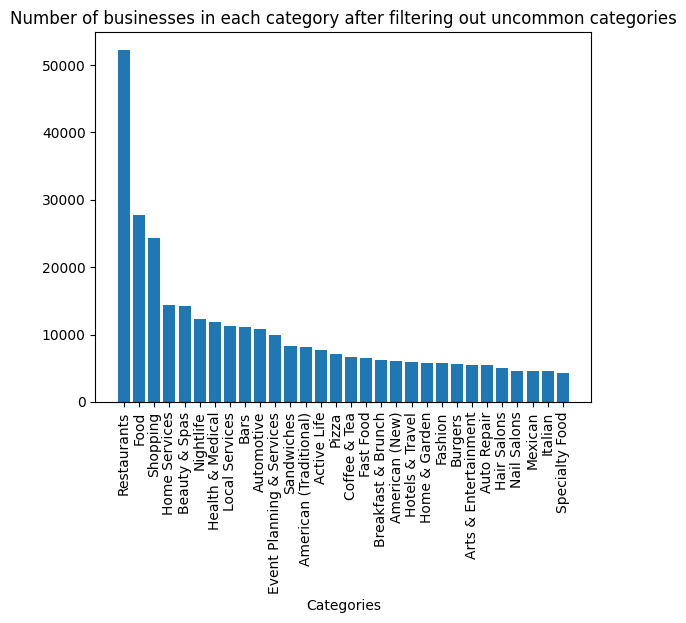

{'Restaurants': 52268,
 'Food': 27781,
 'Shopping': 24395,
 'Home Services': 14356,
 'Beauty & Spas': 14292,
 'Nightlife': 12281,
 'Health & Medical': 11890,
 'Local Services': 11198,
 'Bars': 11065,
 'Automotive': 10773,
 'Event Planning & Services': 9895,
 'Sandwiches': 8366,
 'American (Traditional)': 8139,
 'Active Life': 7687,
 'Pizza': 7093,
 'Coffee & Tea': 6703,
 'Fast Food': 6472,
 'Breakfast & Brunch': 6239,
 'American (New)': 6097,
 'Hotels & Travel': 5857,
 'Home & Garden': 5799,
 'Fashion': 5739,
 'Burgers': 5636,
 'Arts & Entertainment': 5434,
 'Auto Repair': 5433,
 'Hair Salons': 5046,
 'Nail Salons': 4621,
 'Mexican': 4600,
 'Italian': 4573,
 'Specialty Food': 4233}

In [12]:
print(f"Number of businesses before filtering out those with less than {config.top_num_cats_keep}:", len(businesses_df))
filtered_out_uncommon_categories_businesses_df, sorted_top_cats, _ = filter_out_uncommon_categories(non_null_businesses_df, config.top_num_cats_keep)
print(f"Number of businesses after filtering out those with less than {config.top_num_cats_keep}:", len(filtered_out_uncommon_categories_businesses_df))

plt.bar(sorted_top_cats.keys(), [i[1] for i in list(sorted_top_cats.items())])
plt.xlabel("Categories")
title = "Number of businesses in each category after filtering out uncommon categories"
plt.title(title)
plt.xticks(rotation=90)
file_name = title.replace(" ", "_") + ".png"
plt.savefig(f'{os.path.join(config.output_folder, file_name)}')
plt.show()

display(sorted_top_cats)


In [13]:
nlp = spacy.load('en_core_web_sm')

def lemmative(text: str):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

sw = stopwords.words('english')
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.,!¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"http\S+", "",text) #Removing URLs 
    text = re.sub(r"\n", "", text) # Removing new lines
    #text = re.sub(r"http", "",text)
    html = re.compile(r'<.*?>')
    text = html.sub(r'',text) #Removing html tags
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text) #removing stopwords
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    return text

def get_adj(text):
    tokenized = pos_tag(word_tokenize(text), tagset='universal')
    # print(tokenized)
    adjs = [word for word, pos in tokenized if pos == 'ADJ']
    return ' '.join(adjs)

def sentiment_summary(text, fraction=0.3):
    """
    Summarizes text while preserving sentiment.
    
    :param text: The input text to summarize
    :param fraction: The percentage of original text to keep (0.0 to 1.0)
    :return: A summarized version of the text
    """
    sentences = sent_tokenize(text)
    total_sentences = len(sentences)
    
    # Ensure at least 1 sentence is returned
    num_sentences = max(1, int(total_sentences * fraction))

    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(sentences)
    
    sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()
    
    # Get sentiment scores
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [abs(analyzer.polarity_scores(s)['compound']) for s in sentences]
    
    # Combine importance & sentiment (weighted sum)
    combined_scores = sentence_scores * np.array(sentiment_scores)
    
    # Pick top sentences
    top_sentence_indices = combined_scores.argsort()[-num_sentences:][::-1]
    summary = [sentences[i] for i in sorted(top_sentence_indices)]
    
    return " ".join(summary)

In [ ]:
# print("Length of text (total) before cleaning:", reviews_over_min_reviews['text'].apply(len).sum())
# print("Average length of text before cleaning:", reviews_over_min_reviews['text'].apply(len).mean())

# cleaned_reviews = reviews_over_min_reviews.copy()
# cleaned_reviews['text'] = cleaned_reviews['text'].apply(lambda x: clean_text(x))
# print("Length of text (total) after cleaning:", cleaned_reviews['text'].apply(len).sum())
# print("Average length of text after cleaning:", cleaned_reviews['text'].apply(len).mean())

# lemmatized_reviews = cleaned_reviews.copy()
# lemmatized_reviews['text'] = cleaned_reviews['text'].apply(lambda x: lemmative(x))
# print("Length of text (total) after lemmatizing:", lemmatized_reviews['text'].apply(len).sum())
# print("Average length of text after lemmatizing:", lemmatized_reviews['text'].apply(len).mean())

# adj_reviews = lemmatized_reviews.copy()
# adj_reviews['text'] = lemmatized_reviews['text'].apply(lambda x: get_adj(x))
# print("Length of text (total) after getting adjectives:", adj_reviews['text'].apply(len).sum())
# print("Average length of text after getting adjectives:", adj_reviews['text'].apply(len).mean())

# sentiment_summarized_reviews = adj_reviews.copy()
# sentiment_summarized_reviews['text'] = adj_reviews['text'].apply(lambda x: sentiment_summary(x))
# print("Length of text (total) after sentiment summarizing:", sentiment_summarized_reviews['text'].apply(len).sum())
# print("Average length of text after sentiment summarizing:", sentiment_summarized_reviews['text'].apply(len).mean())



Length of text (total) before cleaning: 33183
Average length of text before cleaning: 480.9130434782609
Length of text (total) after cleaning: 20712
Average length of text after cleaning: 300.17391304347825
Length of text (total) after lemmatizing: 19813
Average length of text after lemmatizing: 287.1449275362319
Length of text (total) after getting adjectives: 4684
Average length of text after getting adjectives: 67.8840579710145
Length of text (total) after sentiment summarizing: 4684
Average length of text after sentiment summarizing: 67.8840579710145


In [ ]:
# To inspect the effect of the transformations

# print("Taking a random review and applying transformations to see the effect of each transformation")
# random_index = np.random.randint(0, len(lemmatized_reviews))

# random_review_over_min = reviews_over_min_reviews['text'].iloc[random_index]
# print("Review before cleaning:\n", random_review_over_min)
# print("\n\n")

# random_review_cleaned = cleaned_reviews['text'].iloc[random_index]
# print("Review after cleaning:\n", random_review_cleaned)
# print("\n\n")

# random_review_lemmatized = lemmatized_reviews['text'].iloc[random_index]
# print("Review after lemmatizing:\n", random_review_lemmatized)
# print("\n\n")

# random_review_adj = adj_reviews['text'].iloc[random_index]
# print("Review after adjectivization:\n", random_review_adj)
# print("\n\n")

# random_review_sentiment_summarized = sentiment_summarized_reviews['text'].iloc[random_index]
# print("Review after sentiment summarizing:\n", random_review_sentiment_summarized)
# print("\n\n")

# TODO if going to cap by length, here is space to do it

Taking a random review and applying transformations to see the effect of each transformation
Review before cleaning:
 What a great addition to the Funk Zone!  Grab a bite, grab some tastings, life is good. Right next door to the Santa Barbara Wine Collective, in fact it actually shares the same tables.  We had a fabulous savory croissant.



Review after cleaning:
 great addition funk zone grab bite grab tastings life good right next door santa barbara wine collective fact actually shares tables fabulous savory croissant



Review after lemmatizing:
 great addition funk zone grab bite grab tasting life good right next door santa barbara wine collective fact actually share table fabulous savory croissant



Review after adjectivization:
 great good right next collective table fabulous



Review after sentiment summarizing:
 great good right next collective table fabulous





In [16]:
def calculate_return_guest_percentage(rev_df: pd.DataFrame):
    # Count total unique guests per business
    total_guests = rev_df.groupby('business_id')['user_id'].nunique().reset_index()
    total_guests = total_guests.rename(columns={'user_id': 'total_guest_count'})

    # Count the number of reviews per user per business
    repeat_visits = rev_df.groupby(['business_id', 'user_id']).size().reset_index(name='review_count')

    # Filter businesses where a user has more than one review (return guests)
    repeat_visits = repeat_visits[repeat_visits['review_count'] > 1]

    # Count return guests per business
    return_guests = repeat_visits.groupby('business_id')['user_id'].nunique().reset_index()
    return_guests = return_guests .rename(columns={'user_id': 'return_guest_count'})


    # Merge return guests count with total guests count
    result = total_guests.merge(return_guests, on='business_id', how='left').fillna(0)

    # Calculate return guest percentage
    result['return_percentage'] = (result['return_guest_count'] / result['total_guest_count']) * 100
    result['return_percentage'] = result['return_percentage'].fillna(0)  # Replace NaN with 0%

    return result

In [17]:
# TODO test this and do more analysis on this
# Note: Everything that takes in reviews df (like this) needs to be tested later
# When using the big, full dataset
# And can get rid of two of these because already self-explanatory and in the model already
guest_return_guest_businesses_df = calculate_return_guest_percentage(reviews_over_min_reviews)

guest_return_guest_businesses_df = pd.merge(filtered_out_uncommon_categories_businesses_df, guest_return_guest_businesses_df, on='business_id', how='left')


In [18]:
def trans_func(x):
    # I want from 1 to 10
    if x <= 1:
        return 0
    elif x <= 10 and x > 1:
        return utils.transform_range(x, 1, 10, 1, 5)
    elif x <= 100 and x > 10:
        return utils.transform_range(x, 10, 100, 5, 8)
    else:
        return utils.transform_range(x, 100, 1000, 8, 10)


def get_franchise_score(bus_df: pd.DataFrame):
    name_counts = bus_df['name'].value_counts()

    bus_df['franchise_score'] = bus_df['name'].apply(lambda x: trans_func(name_counts[x])).fillna(0).astype(float)

    return bus_df


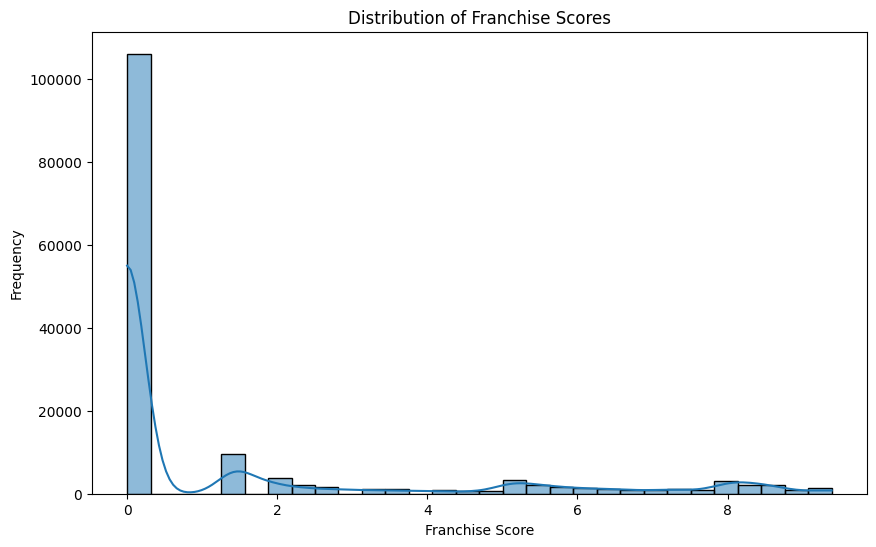

While there are majority businesses with one (or even two) locations there are a few businesses with many locations. Ex: McDonald's, UPS Store, etc.


In [19]:
franchise_score_bus_df = get_franchise_score(guest_return_guest_businesses_df)

# Plotting the distribution of franchise scores
plt.figure(figsize=(10, 6))
sns.histplot(franchise_score_bus_df['franchise_score'], bins=30, kde=True)
plt.xlabel('Franchise Score')
plt.ylabel('Frequency')
title = "Distribution of Franchise Scores"
plt.title(title)
file_name = title.replace(" ", "_") + ".png"
plt.savefig(f'{os.path.join(config.output_folder, file_name)}')
plt.show()

print("While there are majority businesses with one (or even two) locations", 
      "there are a few businesses with many locations. Ex: McDonald's, UPS Store, etc.")

/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option SHAPE_RESTORE_SHX
  return ogr_read(


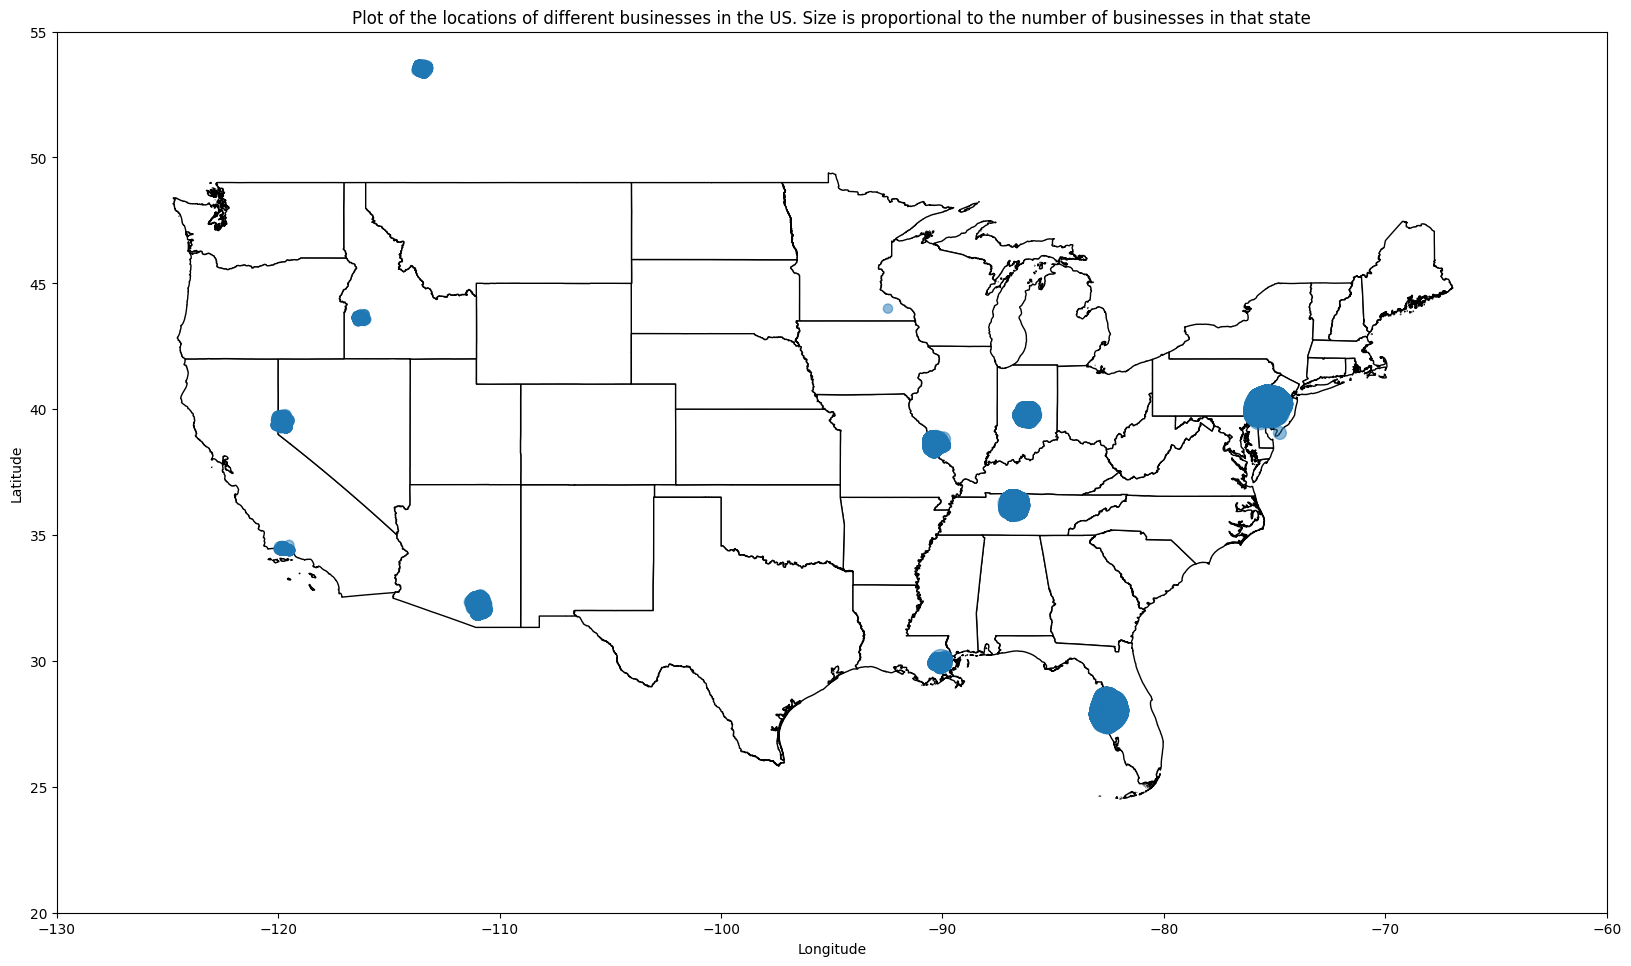

In [20]:
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

gdf = gpd.read_file("inputs/shapefiles/cb_2023_us_state_500k.shp", SHAPE_RESTORE_SHX=True)

gdf = gdf.set_crs('EPSG:4326')

usa = gdf.rename(columns={'STUSPS': 'state'})

fix, ax = plt.subplots(figsize=(20, 12))
gdf.plot(ax=ax, color='white', edgecolor='black')
state_counts = franchise_score_bus_df['state'].value_counts()
sizes = franchise_score_bus_df['state'].map(state_counts)
size_multiplier = 0.01

ax.scatter(franchise_score_bus_df['longitude'], franchise_score_bus_df['latitude'], s=sizes * size_multiplier, alpha=0.5)
title = "Plot of the locations of different businesses in the US. Size is proportional to the number of businesses in that state"
plt.title(title)
file_name = title.replace(" ", "_") + ".png"
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim([-130, -60])  # Adjust the longitude limits as needed
ax.set_ylim([20, 55])
plt.savefig(f'{os.path.join(config.output_folder, file_name)}')
plt.show()

In [21]:
def get_one_hot_state(bus_df: pd.DataFrame):
    return pd.concat([bus_df, pd.get_dummies(bus_df['state'], prefix='state').astype(int)], axis=1)


/tmp/ipykernel_289656/1686648193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')


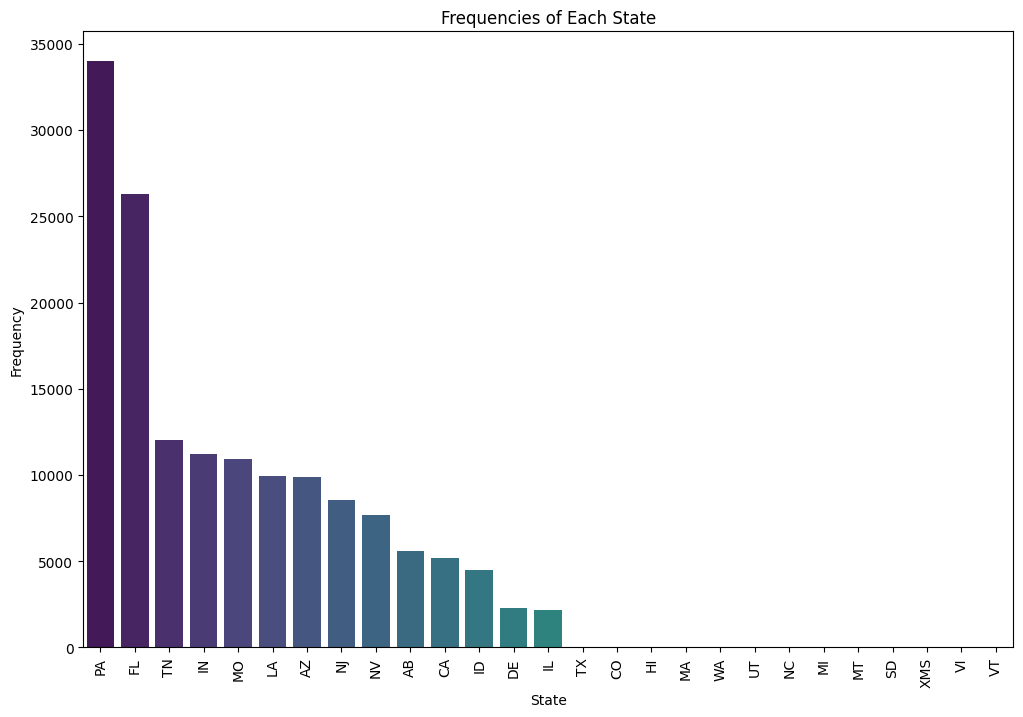

In [22]:
state_bus_df = get_one_hot_state(franchise_score_bus_df)

state_bus_df.iloc[1]

# Plotting the frequencies of each state
state_counts = state_bus_df['state'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
title = 'Frequencies of Each State'
plt.title(title)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
file_name = title.replace(" ", "_") + ".png"
plt.savefig(f'{os.path.join(config.output_folder, file_name)}')
plt.show()

In [23]:
# Find the things with the highest density
# Then plot them and see how close in real life
# 

def get_density_score(bus_df: pd.DataFrame):
    coords = bus_df[['latitude', 'longitude']].T

    kde = gaussian_kde(coords, bw_method=0.1)
    bus_df['density_score'] = kde(coords).astype(float)
    bus_df['density_score'] = utils.transform_range(bus_df['density_score'], bus_df['density_score'].min(), bus_df['density_score'].max(), 0, 1)

    return bus_df

In [24]:
density_score_bus_df = get_density_score(state_bus_df)

density_score_bus_df.iloc[1]

business_id                                      mpf3x-BjTdTEA3yCZrAYPw
name                                                      The UPS Store
address                                 87 Grasso Plaza Shopping Center
city                                                             Affton
state                                                                MO
postal_code                                                       63123
latitude                                                      38.551126
longitude                                                    -90.335695
stars                                                               3.0
review_count                                                         15
is_open                                                               1
attributes                       {'BusinessAcceptsCreditCards': 'True'}
categories                                               Local Services
hours                 {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:3

Describing the density score:  count    150243.000000
mean          0.503200
std           0.327651
min           0.000000
25%           0.229794
50%           0.297946
75%           0.916645
max           1.000000
Name: density_score, dtype: float64
Plotting the places with the highest density score as red triangles and the low density places in blue circles


/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option SHAPE_RESTORE_SHX
  return ogr_read(


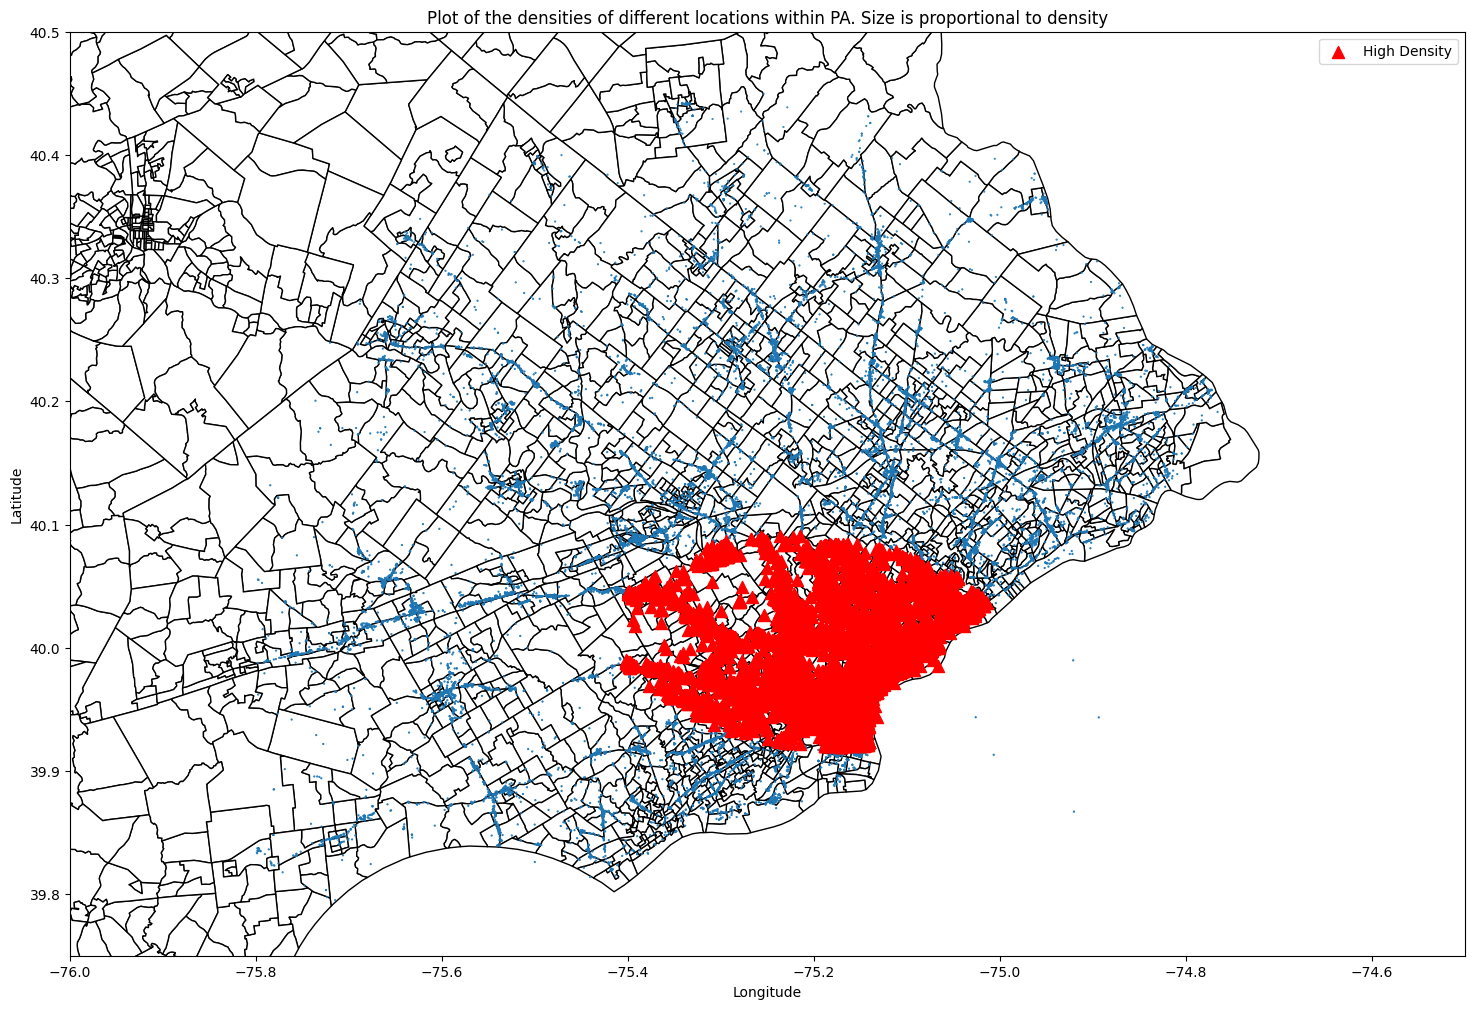

In [25]:
print("Describing the density score: ", density_score_bus_df['density_score'].describe())

print("Plotting the places with the highest density score as red triangles and the low density places in blue circles")

highest_density = density_score_bus_df[density_score_bus_df['density_score'] == density_score_bus_df['density_score'].max()]

os.environ['SHAPE_RESTORE_SHX'] = 'YES'

gdf = gpd.read_file("inputs/shapefiles/cb_2023_42_bg_500k.shp", SHAPE_RESTORE_SHX=True)

gdf = gdf.set_crs('EPSG:4326')

only_PA_bus_df = density_score_bus_df[density_score_bus_df['state'] == 'PA']

fix, ax = plt.subplots(figsize=(20, 12))
gdf.plot(ax=ax, color='white', edgecolor='black')
sizes = only_PA_bus_df['density_score']
size_multiplier = 0.4

threshold = 0.99
high_density_places = only_PA_bus_df[only_PA_bus_df['density_score'] > threshold]


ax.scatter(only_PA_bus_df['longitude'], only_PA_bus_df['latitude'], s=size_multiplier * (sizes ** 2), alpha=1)


ax.scatter(high_density_places['longitude'], high_density_places['latitude'], s=75, color='red', marker='^', label='High Density')

plt.legend()

title = "Plot of the densities of different locations within PA. Size is proportional to density"
plt.title(title)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim([-76, -74.5])
ax.set_ylim([39.75, 40.5])
file_name = title.replace(" ", "_") + ".png"
plt.savefig(f'{os.path.join(config.output_folder, file_name)}')
plt.show()

# Split the data into closed vs. not closed

In [26]:
print("Percentage of businesses that are closed:")
print(density_score_bus_df['is_open'].value_counts(normalize=True) * 100)

Percentage of businesses that are closed:
is_open
1    79.606371
0    20.393629
Name: proportion, dtype: float64


In [27]:
# TODO also need to test when get full review dataset

def get_bus_open_closed(rev_df: pd.DataFrame, cutoff_date='2020-02-01'):
    cutoff_date = pd.to_datetime(cutoff_date)
    last_review_dates = rev_df.groupby('business_id')['date'].max().reset_index()
    print("Last review dates: ", last_review_dates)
    last_review_dates['is_open_after_date'] = last_review_dates['date'].apply(lambda x: 1 if x > cutoff_date else 0)
    return last_review_dates[['business_id', 'date', 'is_open_after_date']]

In [28]:
last_review_dates_bus_df = get_bus_open_closed(reviews_over_min_reviews)

is_open_merged_bus_df = density_score_bus_df.merge(last_review_dates_bus_df, on='business_id', how='inner')
print("Is open merged bus df: ", is_open_merged_bus_df)
print("Len of last review dates bus df: ", len(last_review_dates_bus_df))
print("Len of pre-merged bus df: ", len(density_score_bus_df))
print("Len of merged bus df: ", len(is_open_merged_bus_df))


Last review dates:                 business_id                date
0   04UD14gamNjLY0IDYVhHJg 2015-09-23 23:10:31
1   0ICfbEImE0gUZc4kSZ7QHg 2013-11-14 04:58:09
2   0pMj5xUAecW9o1P35B0AMw 2017-05-26 13:10:24
3   2GYg3liJ9-m6Z67L_4_BRQ 2008-12-03 04:13:43
4   6LCZLGa09Qifn6rG7-DNrg 2015-02-16 07:20:16
..                     ...                 ...
64  rjuWz_AD3WfXJc03AhIO_w 2012-12-04 16:46:20
65  uMvVYRgGNXf5boolA9HXTw 2015-06-21 14:48:06
66  ut6fi2W2YaipNOqvi7e0jw 2014-11-12 14:12:20
67  vC2qm1y3Au5czBtbhc-DNw 2013-09-04 03:48:20
68  x4XdNhp0Xn8lOivzc77J-g 2013-08-15 15:27:51

[69 rows x 2 columns]
Is open merged bus df:                 business_id                             name  \
0   IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
1   SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   
2   CLEWowfkj-wKYJlQDqT1aw   Blow Bar Express Styling Salon   
3   GILL0ZkvVXJaNQzYRXfMQw         Paris Parker Salon & Spa   
4   0pMj5xUAecW9o1P35B0AMw                            

# Dealing with reviews and text data

Right now just going to use ```reviews_over_min_reviews```, which is the basic reviews then going to pad.

Since the average length is 480, which is close to 512 (as of the small reviews df), then we are just going to keep one review and pad/truncate it

In [29]:
# split the dataset into train, val, test
def split_data(bus_df: pd.DataFrame, 
               train_frac=config.train_test_val_split[0], 
               val_frac=config.train_test_val_split[1], 
               test_frac=config.train_test_val_split[2]):
    train, val, test = np.split(bus_df.sample(frac=1), [int(train_frac * len(bus_df)), int((train_frac + val_frac) * len(bus_df))])
    return train, val, test


In [30]:
train_bus_df, val_bus_df, test_bus_df = split_data(is_open_merged_bus_df)

print("Length of original bus df: ", len(is_open_merged_bus_df))
print("Length of train bus df: ", len(train_bus_df))
print("Length of val bus df: ", len(val_bus_df))
print("Length of test bus df: ", len(test_bus_df))


Length of original bus df:  69
Length of train bus df:  48
Length of val bus df:  14
Length of test bus df:  7


/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [31]:
# TODO this is the function to optimize
# At the end of the day, need to get a merged df of the text and the business data
# However I get that text is up to me
# Right now, it just takes the raw, random text of a review for that biz
# It prob pads or truncates in the model itself.
def get_text_for_each_business(bus_df: pd.DataFrame, rev_df: pd.DataFrame, num_sample=1):
    rev_df_bus_df = rev_df.groupby('business_id').apply(lambda x: x.sample(num_sample)).reset_index(drop=True)
    return pd.merge(bus_df, rev_df_bus_df[['business_id', 'text']], on='business_id', how='inner')

In [32]:


full_bus_rev_df = get_text_for_each_business(is_open_merged_bus_df, reviews_over_min_reviews)
train_full_bus_rev_df = get_text_for_each_business(train_bus_df, reviews_over_min_reviews, num_sample=2)
val_full_bus_rev_df = get_text_for_each_business(val_bus_df, reviews_over_min_reviews, num_sample=1)
test_full_bus_rev_df = get_text_for_each_business(test_bus_df, reviews_over_min_reviews, num_sample=1)
print("Giving the test and val datasets only one review per business")

print("Length of full bus rev df: ", len(full_bus_rev_df))
print("Length of density score bus df: ", len(density_score_bus_df))
print("Length of reviews over min reviews: ", len(reviews_over_min_reviews))
print("Length of train full bus rev df: ", len(train_full_bus_rev_df))
print("Because I sample 2 from each business for train, it has double than it should, which is: ", len(train_bus_df))
print("Length of val full bus rev df: ", len(val_full_bus_rev_df))
print("Length of test full bus rev df: ", len(test_full_bus_rev_df))
print("Random sample of full bus rev df: ", full_bus_rev_df.sample(1))

/tmp/ipykernel_289656/3121185637.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rev_df_bus_df = rev_df.groupby('business_id').apply(lambda x: x.sample(num_sample)).reset_index(drop=True)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
def get_useful_features(bus_rev_df: pd.DataFrame):
    to_keep_list = ['latitude', 'longitude', 'stars', 'review_count', 'return_percentage', 'franchise_score', 'density_score', 'text', 'is_open_after_date']
    for state in bus_rev_df['state'].unique():
        to_keep_list.append(f'state_{state}')
    print("All the columns: ", bus_rev_df.columns)
    print("Columns to keep: ", to_keep_list)
    print("Total number of columns to keep: ", len(to_keep_list))

    return to_keep_list

def only_keep_useful_features(bus_rev_df: pd.DataFrame, to_keep_list: list):
    return bus_rev_df[to_keep_list]

In [ ]:
to_keep_list = get_useful_features(full_bus_rev_df)

final_bus_rev_df = only_keep_useful_features(full_bus_rev_df, to_keep_list)

train_final_bus_rev_df = only_keep_useful_features(train_full_bus_rev_df, to_keep_list) 
val_final_bus_rev_df = only_keep_useful_features(val_full_bus_rev_df, to_keep_list)
test_final_bus_rev_df = only_keep_useful_features(test_full_bus_rev_df, to_keep_list)

print("After only keeping useful features...")
print("Shape of final bus rev df: ", final_bus_rev_df.shape)
print("Shape of train final bus rev df: ", train_final_bus_rev_df.shape)
print("Shape of val final bus rev df: ", val_final_bus_rev_df.shape)
print("Shape of test final bus rev df: ", test_final_bus_rev_df.shape)

In [ ]:
# balance the datasets
# TODO need to test and see if this works with full dataset
print("Percentage of the businesses that close/stay open:\n", final_bus_rev_df['is_open_after_date'].value_counts(normalize=True) * 100)

def equalize_data_on_output(rev_bus_df: pd.DataFrame):
    lens = (len(rev_bus_df[rev_bus_df['is_open_after_date'] == 1]), len(rev_bus_df[rev_bus_df['is_open_after_date'] == 0]))
    print("Lens: ", lens)
    min_len = min(lens)
    return rev_bus_df.groupby('is_open_after_date').apply(lambda x: x.sample(min_len)).reset_index(drop=True)

In [ ]:
equalized_final_bus_rev_df = equalize_data_on_output(final_bus_rev_df)

train_equalized_final_bus_rev_df = equalize_data_on_output(train_final_bus_rev_df)


print("Len of equalized final bus rev df: ", len(equalized_final_bus_rev_df))
print("Percentage of the businesses that close/stay open after equalizing:\n", equalized_final_bus_rev_df['is_open_after_date'].value_counts(normalize=True) * 100)
print("Len of train equalized final bus rev df: ", len(train_equalized_final_bus_rev_df))
print("Percentage of the train businesses that close/stay open after equalizing:\n", train_equalized_final_bus_rev_df['is_open_after_date'].value_counts(normalize=True) * 100)
print("Percentage of the val businesses that close/stay open after equalizing:\n", val_final_bus_rev_df['is_open_after_date'].value_counts(normalize=True) * 100)
print("Percentage of the test businesses that close/stay open after equalizing:\n", test_final_bus_rev_df['is_open_after_date'].value_counts(normalize=True) * 100)

# Create tensors

Tokenize text and create tensors

In [ ]:
def get_data_tensors(final_bus_rev_df: pd.DataFrame, output_var='is_open_after_date'):
    all_columns = final_bus_rev_df.columns

    text_inputs = final_bus_rev_df['text'].values

    nn_input_features = [col for col in all_columns if col != 'text' and col != output_var]

    for feature in nn_input_features:
        final_bus_rev_df[feature] = pd.to_numeric(final_bus_rev_df[feature], errors='coerce').fillna(0)

    print("Features for nn: ", nn_input_features)

    nn_inputs = torch.tensor(final_bus_rev_df[nn_input_features].values, dtype=torch.float32)

    print("NN input shape: ", nn_inputs.shape)
    print("Sample NN input: ", nn_inputs[0])

    input_ids = []
    attention_masks = []

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    for rev in text_inputs:
        encoded_dict = tokenizer.encode_plus(
            rev,
            add_special_tokens=True,
            padding='max_length',
            max_length=config.tokenizer_max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    outputs = torch.tensor(final_bus_rev_df[output_var].values, dtype=torch.float32)

    return input_ids, attention_masks, nn_inputs, outputs



In [ ]:
def create_train_val_test_tensors(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame):
    names = ['train', 'val', 'test']
    for i, df in enumerate([train_df, val_df, test_df]):
        input_ids, attention_masks, nn_inputs, outputs = get_data_tensors(df)
        torch.save({'input_ids': input_ids, 'attention_masks': attention_masks, 'nn_inputs': nn_inputs, 'outputs': outputs}, 
            os.path.join(config.output_folder, f'all_tensors_percentage_{config.frac_reviews_load}_{names[i]}.pth'))

In [ ]:
create_train_val_test_tensors(train_equalized_final_bus_rev_df, val_final_bus_rev_df, test_final_bus_rev_df)

In [ ]:
import pandas as pd

# Set display options to avoid truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

print("Printing sample businesses, their text, and their output variable")

for i in range(5):
    bus = test_full_bus_rev_df.sample(1)
    print("Business name: ", bus['name'].values[0])
    print('Business text: ', bus['text'].values[0])
    print('Business output variable: ', bus['is_open_after_date'].values[0])
    print("Business all data: \n", bus)
    print("\n\n")

In [ ]:
# save the config's state dict as a file
with open(os.path.join(config.output_folder, 'config.json'), 'w') as f:
    json.dump(config.__dict__, f, indent=4)

utils.send_email(f"✅ Finished {config.filename} execution", f"Took {utils.get_time_from_start(start_time)}\nConfig: {config.__dict__}")

In [ ]:
# Honestly not really used here, but I'm keeping it here for now
def save_to_parquet(df, path, percentage_of_total_data=1.0):
    new_path = utils.get_next_filename(f'{path}_percentage_{percentage_of_total_data}.parquet')
    df.to_parquet(new_path, engine='pyarrow')
    print(f"Saved to {new_path}")

# save_to_parquet(lemmatized_reviews, f"data/{file_name}", config.frac_reviews_load)

In [ ]:
# TODO finish the end of the command
# utils.send_email("✅ Finished {file_name} execution", f"Took {utils.get_time_from_start(start_time)}\nPercentage of total reviews loaded: {constants.frac_reviews_load}\nPercentage of total businesses loaded: {config.frac_businesses_load}\n Saved to")